In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from zipfile import ZipFile

In [2]:
with ZipFile("archive.zip","r") as zip:
    zip.extractall()

In [3]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

batch_size = 32
img_size = (128,128)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed = 123,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "val",
    seed = 123,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

Found 357507 files belonging to 2 classes.
Found 71504 files belonging to 2 classes.


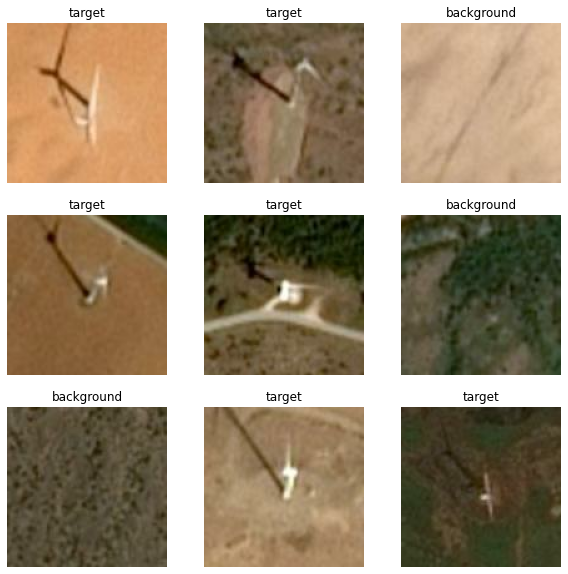

In [5]:
class_names = train_ds.class_names

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
])

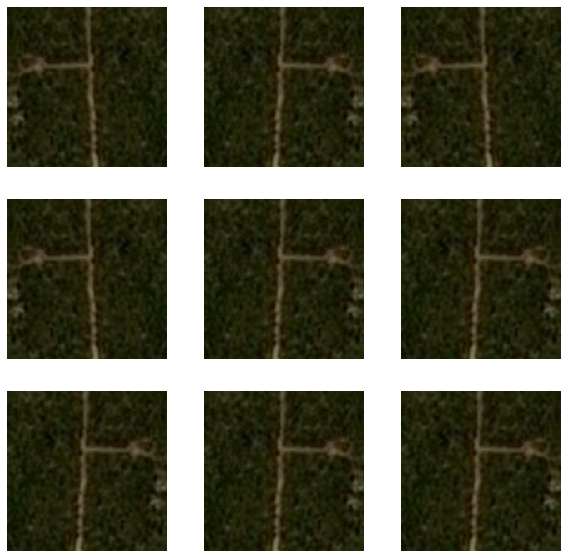

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Define the model

In [9]:
def model():
    inputs = tf.keras.Input(shape=(128,128,3))
    x = data_augmentation(inputs)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv2D(64,3,activation="relu",padding="same",strides=(2,2),kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128,3,activation="relu",padding="same",strides=(2,2),kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Conv2D(128,3,activation="relu",padding="same",strides=(2,2),kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Conv2D(256,3,activation="relu",padding="same",strides=(2,2),kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64,activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4,seed=123)(x)
    x = tf.keras.layers.Dense(32,activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4,seed=123)(x)
    outputs = tf.keras.layers.Dense(2)(x)
    model = tf.keras.Model(inputs,outputs)
    return model

model = model()
model.summary()
model.compile(tf.keras.optimizers.Adam(),tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584

### Train and test the model on Test dataset

In [10]:
if __name__=="__main__":
    epochs = 3
    loss0,accuracy0 = model.evaluate(val_ds)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("airbus.h5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=[checkpoint])
    best = tf.keras.models.load_model("airbus.h5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nTest accuracy: {:.2f} %".format(100*accuracy))
    print("Test loss: {:.2f} %".format(100*loss))

1788/1788 [==============================] - 12s 5ms/step - loss: 0.7307 - accuracy: 0.5672
Epoch 1/3
11173/11173 [==============================] - 179s 16ms/step - loss: 0.1054 - accuracy: 0.9693 - val_loss: 0.0651 - val_accuracy: 0.9838
Epoch 2/3
11173/11173 [==============================] - 181s 16ms/step - loss: 0.0701 - accuracy: 0.9827 - val_loss: 0.0588 - val_accuracy: 0.9860
Epoch 3/3
447/447 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.9876

Test accuracy: 98.76 %
Test loss: 5.33 %
